<a href="https://colab.research.google.com/github/nandivardhan522/Customer_Insights_and_Purchase_Behavior_Prediction/blob/main/Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 1 - Replicating Models from Class

In [2]:
pip install prettytable

In [3]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import math
from scipy.stats import poisson
from scipy.special import gamma
from scipy.stats import nbinom

### 1. Developing Models - Hard Candy Example

#### a. Poisson Model (Hard Candy Data)

In [5]:
# Bringing in Billboard Dataset

# Load the dataset
candy = pd.read_csv("/content/sample_data/candy.csv")

# Variable Types
print("Data Type: ")
print(candy.dtypes)
print("")

# Shape of the dataset
print("Shape of dataframe: ", candy.shape)
print("")

# First five records in the dataset
print(candy.head(5))

Data Type: 
Packs     int64
People    int64
dtype: object

Shape of dataframe:  (21, 2)

   Packs  People
0      0     102
1      1      54
2      2      49
3      3      62
4      4      44


In [6]:
# Defining functions to calculate probability p(x=k) and negative log likelihood of the poisson distribution
# Poisson Model Parameter - lambda, k- packs, x- people
# Defining Probability Function
def psnmdl_prob_p1a(lambda_, k):
    return (lambda_**k * np.exp(-lambda_) / math.factorial(k))

def psnmdl_neg_log_likelihood_p1a(params, k, x):
    lambda_ = params[0]
    likelihoods = [psnmdl_prob_p1a(lambda_, k_i) for k_i in k]
    log_likelihoods = np.log(likelihoods)
    return -np.sum(x * log_likelihoods)

# Storing the variables as array
k = candy['Packs'].values
x = candy['People'].values

# Using python optimization to minimize the negative log-likelihood of the poisson distribution
psnmdl_soln_p1a = minimize(
    psnmdl_neg_log_likelihood_p1a,
    args=(k, x),
    x0=np.array([1.0]),
    bounds=[(0.000001, None)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated Poisson model parameter and maximum log-likelihood
estimated_lambda_p1a = psnmdl_soln_p1a.x[0]
max_log_likelihood_psnmdl_p1a = -psnmdl_soln_p1a.fun

# Print the results
print("Poisson Model (Candy Dataset) Estimated Values:")
print("Estimated Poisson parameter (lambda):", estimated_lambda_p1a)
print("Maximum Log-Likelihood (Poisson Model):", max_log_likelihood_psnmdl_p1a)

Poisson Model (Candy Dataset) Estimated Values:
Estimated Poisson parameter (lambda): 3.9912278692038283
Maximum Log-Likelihood (Poisson Model): -1544.996390448969


In [7]:
# Predict the number of people for k exposures
total_people = sum(x)
exposures_to_predict = k

# Calculate the Poisson probabilities
probabilities_p1a = [psnmdl_prob_p1a(estimated_lambda_p1a, k_i) for k_i in k]

# Calculate the predicted number of people
predicted_people_psnmdl_p1a = [int(prob * total_people) for prob in probabilities_p1a]

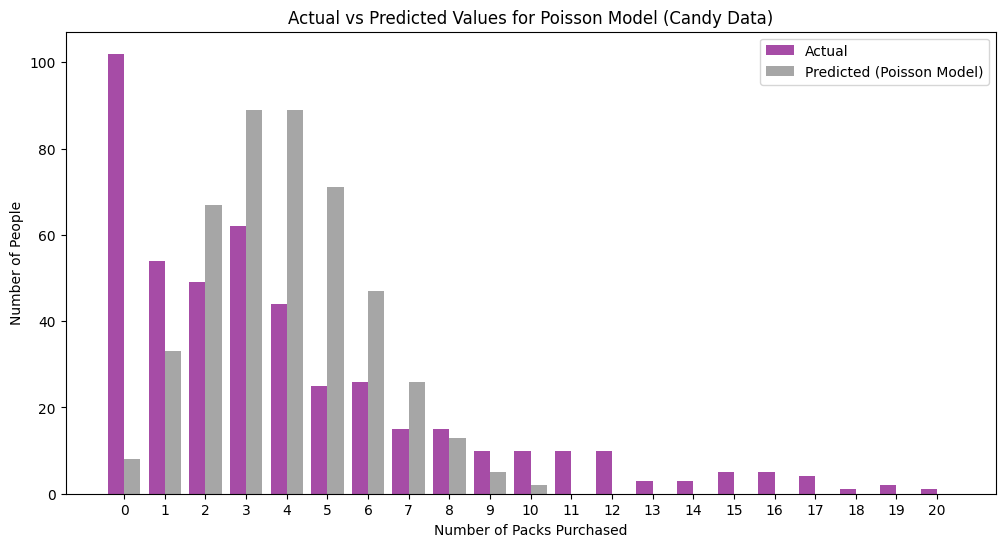

In [8]:
#Plot for Actual and Predicted values using Poisson Model (Billboard Data)
bar_width = 0.4
index = np.arange(len(k))

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_psnmdl_p1a, width=bar_width, alpha=0.7, label='Predicted (Poisson Model)', color='gray')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for Poisson Model (Candy Data)')
plt.xticks(index + bar_width / 2, k)
plt.legend()
plt.show()

#### b. NBD Model (Candy Data)

In [9]:
# Defining functions to calculate probability p(x=k) and negative log likelihood of the nbd distribution
def nbdmdl_prob_p1b(params, k):
    alpha, n = params
    prob = []
    obsLength = list(range(0, len(k)))
    for i in obsLength:
        if i == 0:
            prob.append((alpha/(alpha+1))**n)
        else:
            prob.append(prob[-1]*(n+k[i]-1)/(k[i]*(alpha+1)))
    return prob

def nbdmdl_log_likelihood_p1b(params, k, x):
    alpha, n = params
    prob = []
    nbll = 0
    obsLength = list(range(0, len(k)))
    for i in obsLength:
        if i == 0:
            prob.append((alpha/(alpha+1))**n)
            nbll = x[i] * np.log(prob[i])
        else:
            prob.append(prob[-1]*(n+k[i]-1)/(k[i]*(alpha+1)))
            nbll += x[i] * np.log(prob[i])
    return nbll

def nbdmdl_neg_log_likelihood_p1b(params, k, x):
    return -nbdmdl_log_likelihood_p1b(params, k, x)

In [10]:
# Initial guess for NBD parameters (alpha, shape)
initial_params_p1b = np.array([1,0.5])

# Perform Maximum Likelihood Estimation for NBD
nbdmdl_soln_p1b = minimize(
    nbdmdl_neg_log_likelihood_p1b,
    x0=initial_params_p1b,
    args=(k, x),
    bounds=[(0.000001, None), (0.000001, 1.0)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated NBD parameters and maximum log-likelihood
estimated_alpha_p1b, estimated_shape_p1b = nbdmdl_soln_p1b.x
max_log_likelihood_nbdmdl_p1b = -nbdmdl_soln_p1b.fun

# Print the results
print("NBD Model (Candy Dataset) Estimated Values:")
print("")
print("Estimated NBD parameters (alpha, shape):", estimated_alpha_p1b, estimated_shape_p1b)
print("Maximum Log-Likelihood (NBD):", max_log_likelihood_nbdmdl_p1b)

NBD Model (Candy Dataset) Estimated Values:

Estimated NBD parameters (alpha, shape): 0.2499636938580261 0.9976641804701156
Maximum Log-Likelihood (NBD): -1140.0237461879096


In [11]:
# Predict the number of people for 0 to 23 exposures based on the NBD model
predicted_people_nbdmdl_p1b = []

probabilities_p1b = nbdmdl_prob_p1b([estimated_alpha_p1b, estimated_shape_p1b], exposures_to_predict)
predicted_people_nbdmdl_p1b = [int(p * total_people) for p in probabilities_p1b]

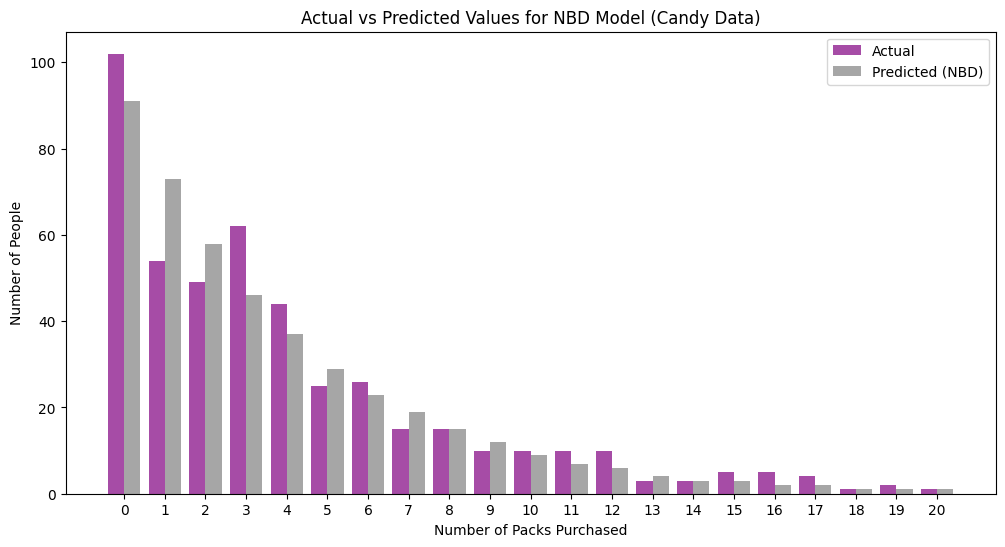

In [12]:
# Graph for original and predicted number of exposures

bar_width = 0.4
index = np.arange(len(k))

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_nbdmdl_p1b, width=bar_width, alpha=0.7, label='Predicted (NBD)', color='gray')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for NBD Model (Candy Data)')
plt.xticks(index + bar_width / 2, k)
plt.legend()
plt.show()

#### c. Zero Inflated NBD Model (Candy Data)

In [13]:
# Defining functions to calculate probability p(x=k) and negative log likelihood of the nbd distribution

def zinbdmdl_prob_p1c(params, k):
    pi, alpha, n = params
    prob = []

    for i in list(range(0,len(k))):
        if i == 0:
            prob.append(pi+(1-pi)*((gamma(n+k[i])/(gamma(n)*math.factorial(k[i]))) * (alpha/(alpha+1))**n * (1/(alpha+1))**k[i]))
        else:
            prob.append((1-pi)*((gamma(n+k[i])/(gamma(n)*math.factorial(k[i]))) * (alpha/(alpha+1))**n * (1/(alpha+1))**k[i]))
    return prob

def zinbdmdl_log_likelihood_p1c(params, k, x):
    pi, alpha, n = params
    zinbdll = 0
    prob = []

    for i in list(range(0,len(k))):
        if i == 0:
            prob.append(pi+(1-pi)*((gamma(n+k[i])/(gamma(n)*math.factorial(k[i]))) * (alpha/(alpha+1))**n * (1/(alpha+1))**k[i]))
            zinbdll = x[i] * np.log(prob[i])
        else:
            prob.append((1-pi)*((gamma(n+k[i])/(gamma(n)*math.factorial(k[i]))) * (alpha/(alpha+1))**n * (1/(alpha+1))**k[i]))
            zinbdll += x[i] * np.log(prob[i])
    return zinbdll

def zinbdmdl_neg_log_likelihood_p1c(params, k, x):
    return -zinbdmdl_log_likelihood_p1c(params, k, x)

In [14]:
# Initial guess for ZI NBD parameters (pi, alpha, shape)
initial_params_p1c = np.array([0.02, 1, 0.5])

# Perform Maximum Likelihood Estimation for NBD
zinbdmdl_soln_p1c = minimize(
    zinbdmdl_neg_log_likelihood_p1c,
    x0=initial_params_p1c,
    args=(k, x),
    bounds=[(0.000001,0.99999),(0.000001, None), (0.000001, None)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated ZI NBD parameters and maximum log-likelihood
estimated_pi_p1c, estimated_alpha_p1c, estimated_shape_p1c = zinbdmdl_soln_p1c.x
max_log_likelihood_zinbdmdl_p1c = -zinbdmdl_soln_p1c.fun

# Print the results
print("Zero Inflated NBD Model (Candy Dataset) Estimated Values:")
print("")
print("Estimated Zero Inflated NBD parameters (pi, alpha, shape):", estimated_pi_p1c, estimated_alpha_p1c, estimated_shape_p1c)
print("Maximum Log-Likelihood (ZI NBD):", max_log_likelihood_zinbdmdl_p1c)

Zero Inflated NBD Model (Candy Dataset) Estimated Values:

Estimated Zero Inflated NBD parameters (pi, alpha, shape): 0.11310370076049828 0.3341876580996791 1.5039185087655875
Maximum Log-Likelihood (ZI NBD): -1136.1656408319284


In [15]:
# Predict the number of people for k exposures based on the ZI NBD model
predicted_people_zinbdmdl_p1c = []

probabilities_p1c = zinbdmdl_prob_p1c([estimated_pi_p1c, estimated_alpha_p1c, estimated_shape_p1c], exposures_to_predict)
predicted_people_zinbdmdl_p1c = [int(p * total_people) for p in probabilities_p1c]

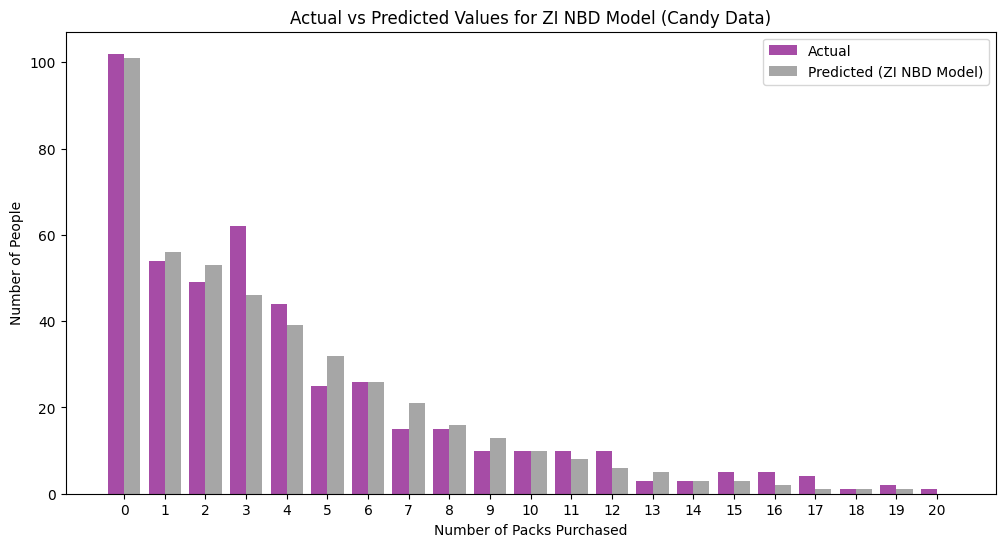

In [16]:
# Graph for original and predicted number of exposures

bar_width = 0.4
index = np.arange(len(k))

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_zinbdmdl_p1c, width=bar_width, alpha=0.7, label='Predicted (ZI NBD Model)', color='gray')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for ZI NBD Model (Candy Data)')
plt.xticks(index + bar_width / 2, k)
plt.legend()
plt.show()

#### d. Finite Mixture Models for 2, 3, and 4 segments (Candy Data)

##### 2 segment (Candy Data)

In [17]:
def fmm2segmdl_prob_p1d(params, k):
    lambda1, lambda2, pi1 = params
    seg1, seg2, prob = [], [], []
    ffm2ll = 0

    for i in range(0, len(k)):
        seg1.append(poisson.pmf(k[i], lambda1))
        seg2.append(poisson.pmf(k[i], lambda2))
        prob.append(pi1*seg1[i] + (1-pi1)*seg2[i])
    return prob

def fmm2segmdl_log_likelihood_p1d(params, k, x):
    lambda1, lambda2, pi1 = params
    seg1, seg2, prob = [], [], []
    ffm2ll = 0

    for i in range(0, len(k)):
        seg1.append(poisson.pmf(k[i], lambda1))
        seg2.append(poisson.pmf(k[i], lambda2))
        prob.append(pi1*seg1[i] + (1-pi1)*seg2[i])
        ffm2ll += x[i] * np.log(prob[i])
    return ffm2ll

def fmm2segmdl_neg_log_likelihood_p1d(params, k, x):
    return -fmm2segmdl_log_likelihood_p1d(params, k, x)

In [18]:
# Initial guess for Finite Mixture 2 Segment Model parameters (lambda1, lambda2, pi1)
initial_params_p1d = np.array([0.01, 0.02, 0.01])


# Perform Maximum Likelihood Estimation for Finite Mixture 2 Segment Model
fmm2segmdl_soln_p1d = minimize(
    fmm2segmdl_neg_log_likelihood_p1d,
    x0=initial_params_p1d,
    args=(k, x),
    bounds=[(0.000001,None),(0.000001, None), (0.000001, 0.99999)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated NBD parameters and maximum log-likelihood
estimated_lambda1_fmm2p1d, estimated_lambda2_fmm2p1d, estimated_pi1_fmm2p1d = fmm2segmdl_soln_p1d.x
max_log_likelihood_fmm2segmdl_p1d = -fmm2segmdl_soln_p1d.fun

# Print the results
print("Finite Mixture 2 Segment Model (Candy Dataset) Estimated Values:")
print("")
print("Estimated Finite Mixture 2 Segment Model parameters (lambda1, lambda2, pi1):", estimated_lambda1_fmm2p1d, estimated_lambda2_fmm2p1d, estimated_pi1_fmm2p1d)
print("Maximum Log-Likelihood (ZI NBD):", max_log_likelihood_fmm2segmdl_p1d)

Finite Mixture 2 Segment Model (Candy Dataset) Estimated Values:

Estimated Finite Mixture 2 Segment Model parameters (lambda1, lambda2, pi1): 1.8021535211489903 9.120686057554176 0.7008860871584063
Maximum Log-Likelihood (ZI NBD): -1188.8328271724242


In [20]:
# Predict the number of people for k exposures based on the Finite Mixture 2 Segment model
predicted_people_fmm2segmdl_p1d = []

probabilities_p1d = fmm2segmdl_prob_p1d([estimated_lambda1_fmm2p1d, estimated_lambda2_fmm2p1d, estimated_pi1_fmm2p1d], exposures_to_predict)
predicted_people_fmm2segmdl_p1d = [int(p * total_people) for p in probabilities_p1d]

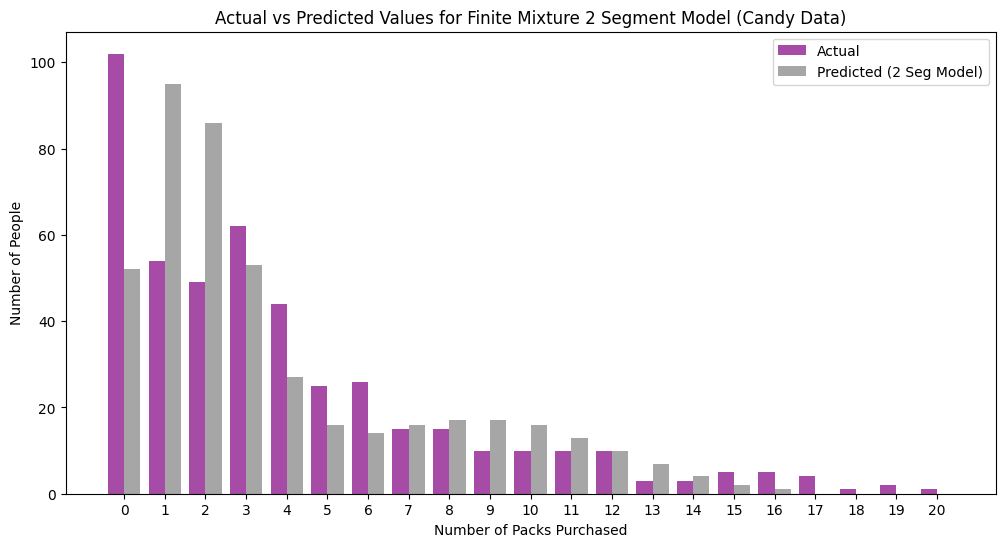

In [21]:
# Graph for original and predicted number of exposures

bar_width = 0.4
index = np.arange(len(k))

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_fmm2segmdl_p1d, width=bar_width, alpha=0.7, label='Predicted (2 Seg Model)', color='gray')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for Finite Mixture 2 Segment Model (Candy Data)')
plt.xticks(index + bar_width / 2, k)
plt.legend()
plt.show()

##### 3 segment (Candy Data)

In [22]:
def fmm3segmdl_prob_p1d(params, k):
    lambda1, lambda2, lambda3, theta1, theta2 = params
    seg1, seg2, seg3, prob = [], [], [], []
    ffm3ll = 0
    theta3 = 0

    exp_theta1 = np.exp(theta1)
    exp_theta2 = np.exp(theta2)
    exp_theta3 = np.exp(theta3)

    sum_thetas = exp_theta1+exp_theta2+exp_theta3

    pi1 = exp_theta1/sum_thetas
    pi2 = exp_theta2/sum_thetas
    pi3 = exp_theta3/sum_thetas

    for i in range(0, len(k)):
        seg1.append(poisson.pmf(k[i], lambda1))
        seg2.append(poisson.pmf(k[i], lambda2))
        seg3.append(poisson.pmf(k[i], lambda3))
        prob.append(pi1*seg1[i] + pi2*seg2[i] + pi3*seg3[i])
    return prob


def fmm3segmdl_log_likelihood_p1d(params, k, x):
    lambda1, lambda2, lambda3, theta1, theta2 = params
    seg1, seg2, seg3, prob = [], [], [], []
    ffm3ll = 0
    theta3 = 0

    exp_theta1 = np.exp(theta1)
    exp_theta2 = np.exp(theta2)
    exp_theta3 = np.exp(theta3)

    sum_thetas = exp_theta1+exp_theta2+exp_theta3

    pi1 = exp_theta1/sum_thetas
    pi2 = exp_theta2/sum_thetas
    pi3 = exp_theta3/sum_thetas

    for i in range(0, len(k)):
        seg1.append(poisson.pmf(k[i], lambda1))
        seg2.append(poisson.pmf(k[i], lambda2))
        seg3.append(poisson.pmf(k[i], lambda3))
        prob.append(pi1*seg1[i] + pi2*seg2[i] + pi3*seg3[i])
        ffm3ll += x[i] * np.log(prob[i])
    return ffm3ll

def fmm3segmdl_neg_log_likelihood_p1d(params, k, x):
    return -fmm3segmdl_log_likelihood_p1d(params, k, x)

In [24]:
# Initial guess for Finite Mixture 3 Segment Model parameters (lambda1, lambda2, lambda3, theta1, theta2)
initial_params_p1d = np.array([0.05, 0.05, 0.02, 0.01, 0.02])


# Perform Maximum Likelihood Estimation for Finite Mixture 3 Segment Model
fmm3segmdl_soln_p1d = minimize(
    fmm3segmdl_neg_log_likelihood_p1d,
    x0=initial_params_p1d,
    args=(k, x),
    bounds=[(0.000001,None),(0.000001, None), (0.000001, None), (None, None), (None, None)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated NBD parameters and maximum log-likelihood
estimated_lambda1_fmm3p1d, estimated_lambda2_fmm3p1d, estimated_lambda3_fmm3p1d, estimated_theta1_fmm3p1d, estimated_theta2_fmm3p1d = fmm3segmdl_soln_p1d.x
max_log_likelihood_fmm3segmdl_p1d = -fmm3segmdl_soln_p1d.fun

# Print the results
print("Finite Mixture 3 Segment Model (Candy Dataset) Estimated Values:")
print("")
print("Estimated Finite Mixture 3 Segment Model parameters (lambda1, lambda2,lambda3, theta1, theta2):", estimated_lambda1_fmm3p1d, estimated_lambda2_fmm3p1d, estimated_lambda3_fmm3p1d, estimated_theta1_fmm3p1d, estimated_theta2_fmm3p1d)
print("Maximum Log-Likelihood (Finite Mixture 3 Segment Model):", max_log_likelihood_fmm3segmdl_p1d)

Finite Mixture 3 Segment Model (Candy Dataset) Estimated Values:

Estimated Finite Mixture 3 Segment Model parameters (lambda1, lambda2,lambda3, theta1, theta2): 3.48337070933276 11.215912174077538 0.2905151612455488 0.6744646396142554 -0.4304445259727132
Maximum Log-Likelihood (Finite Mixture 3 Segment Model): -1132.0429844099829


In [25]:
# Predict the number of people for k exposures based on the Finite Mixture 3 Segment model
predicted_people_fmm3segmdl_p1d = []

probabilities_p1d = fmm3segmdl_prob_p1d([estimated_lambda1_fmm3p1d, estimated_lambda2_fmm3p1d, estimated_lambda3_fmm3p1d, estimated_theta1_fmm3p1d, estimated_theta2_fmm3p1d], exposures_to_predict)
predicted_people_fmm3segmdl_p1d = [int(p * total_people) for p in probabilities_p1d]

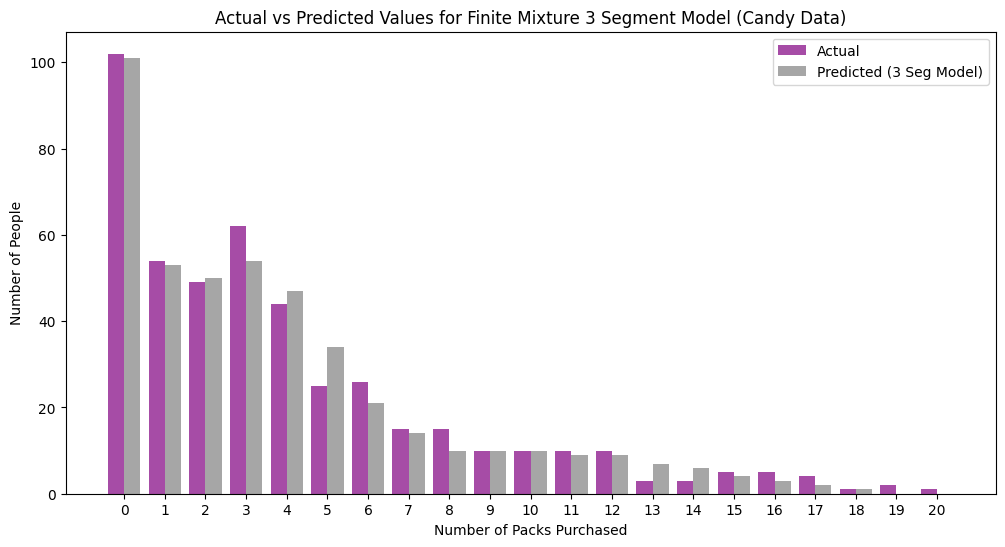

In [26]:
# Graph for original and predicted number of exposures

bar_width = 0.4
index = np.arange(len(k))

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_fmm3segmdl_p1d, width=bar_width, alpha=0.7, label='Predicted (3 Seg Model)', color='gray')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for Finite Mixture 3 Segment Model (Candy Data)')
plt.xticks(index + bar_width / 2, k)
plt.legend()
plt.show()

##### 4 segment (Candy Data)

In [27]:
def fmm4segmdl_prob_p1d(params, k):
    lambda1, lambda2, lambda3, lambda4, theta1, theta2, theta3 = params
    seg1, seg2, seg3, seg4, prob = [], [], [], [], []
    ffm4ll = 0
    theta4 = 0

    exp_theta1 = np.exp(theta1)
    exp_theta2 = np.exp(theta2)
    exp_theta3 = np.exp(theta3)
    exp_theta4 = np.exp(theta4)

    sum_thetas = exp_theta1+exp_theta2+exp_theta3+exp_theta4

    pi1 = exp_theta1/sum_thetas
    pi2 = exp_theta2/sum_thetas
    pi3 = exp_theta3/sum_thetas
    pi4 = exp_theta4/sum_thetas

    for i in range(0, len(k)):
        seg1.append(poisson.pmf(k[i], lambda1))
        seg2.append(poisson.pmf(k[i], lambda2))
        seg3.append(poisson.pmf(k[i], lambda3))
        seg4.append(poisson.pmf(k[i], lambda4))
        prob.append(pi1*seg1[i] + pi2*seg2[i] + pi3*seg3[i] +pi4*seg4[i])
    return prob


def fmm4segmdl_log_likelihood_p1d(params, k, x):
    lambda1, lambda2, lambda3, lambda4, theta1, theta2, theta3 = params
    seg1, seg2, seg3, seg4, prob = [], [], [], [], []
    ffm4ll = 0
    theta4 = 0

    exp_theta1 = np.exp(theta1)
    exp_theta2 = np.exp(theta2)
    exp_theta3 = np.exp(theta3)
    exp_theta4 = np.exp(theta4)

    sum_thetas = exp_theta1+exp_theta2+exp_theta3+exp_theta4

    pi1 = exp_theta1/sum_thetas
    pi2 = exp_theta2/sum_thetas
    pi3 = exp_theta3/sum_thetas
    pi4 = exp_theta4/sum_thetas

    for i in range(0, len(k)):
        seg1.append(poisson.pmf(k[i], lambda1))
        seg2.append(poisson.pmf(k[i], lambda2))
        seg3.append(poisson.pmf(k[i], lambda3))
        seg4.append(poisson.pmf(k[i], lambda4))
        prob.append(pi1*seg1[i] + pi2*seg2[i] + pi3*seg3[i] +pi4*seg4[i])
        ffm4ll += x[i] * np.log(prob[i])
    return ffm4ll

def fmm4segmdl_neg_log_likelihood_p1d(params, k, x):
    return -fmm4segmdl_log_likelihood_p1d(params, k, x)

In [29]:
# Initial guess for Finite Mixture 4 Segment Model parameters (lambda1, lambda2, lambda3, lambda4, theta1, theta2, theta3)
initial_params_p1d = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.02])

# Perform Maximum Likelihood Estimation for Finite Mixture 4 Segment Model
fmm4segmdl_soln_p1d = minimize(
    fmm4segmdl_neg_log_likelihood_p1d,
    x0=initial_params_p1d,
    args=(k, x),
    bounds=[(0.000001,None),(0.000001, None), (0.000001, None), (0.000001, None), (None, None), (None, None), (None, None)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated NBD parameters and maximum log-likelihood
estimated_lambda1_fmm4p1d, estimated_lambda2_fmm4p1d, estimated_lambda3_fmm4p1d, estimated_lambda4_fmm4p1d, estimated_theta1_fmm4p1d, estimated_theta2_fmm4p1d, estimated_theta3_fmm4p1d = fmm4segmdl_soln_p1d.x
max_log_likelihood_fmm4segmdl_p1d = -fmm4segmdl_soln_p1d.fun

# Print the results
print("Finite Mixture 4 Segment Model (Candy Dataset) Estimated Values:")
print("")
print("Estimated Finite Mixture 4 Segment Model parameters (lambda1, lambda2, lambda3, theta1, theta2, theta3):", estimated_lambda1_fmm4p1d, estimated_lambda2_fmm4p1d, estimated_lambda3_fmm4p1d, estimated_lambda4_fmm4p1d, estimated_theta1_fmm4p1d, estimated_theta2_fmm4p1d, estimated_theta3_fmm4p1d)
print("Maximum Log-Likelihood (Finite Mixture 4 Segment Model):", max_log_likelihood_fmm4segmdl_p1d)

Finite Mixture 4 Segment Model (Candy Dataset) Estimated Values:

Estimated Finite Mixture 4 Segment Model parameters (lambda1, lambda2, lambda3, theta1, theta2, theta3): 7.418270719589816 3.0019202302244943 12.872583216092373 0.20470930000653137 -0.478018639706003 0.7221211606514268 -0.8759818166183413
Maximum Log-Likelihood (Finite Mixture 4 Segment Model): -1130.0705911210619


In [30]:
# Predict the number of people for k exposures based on the Finite Mixture 2 Segment model
predicted_people_fmm4segmdl_p1d = []

probabilities_p1d = fmm4segmdl_prob_p1d([estimated_lambda1_fmm4p1d, estimated_lambda2_fmm4p1d, estimated_lambda3_fmm4p1d, estimated_lambda4_fmm4p1d, estimated_theta1_fmm4p1d, estimated_theta2_fmm4p1d, estimated_theta3_fmm4p1d], exposures_to_predict)
predicted_people_fmm4segmdl_p1d = [int(p * total_people) for p in probabilities_p1d]

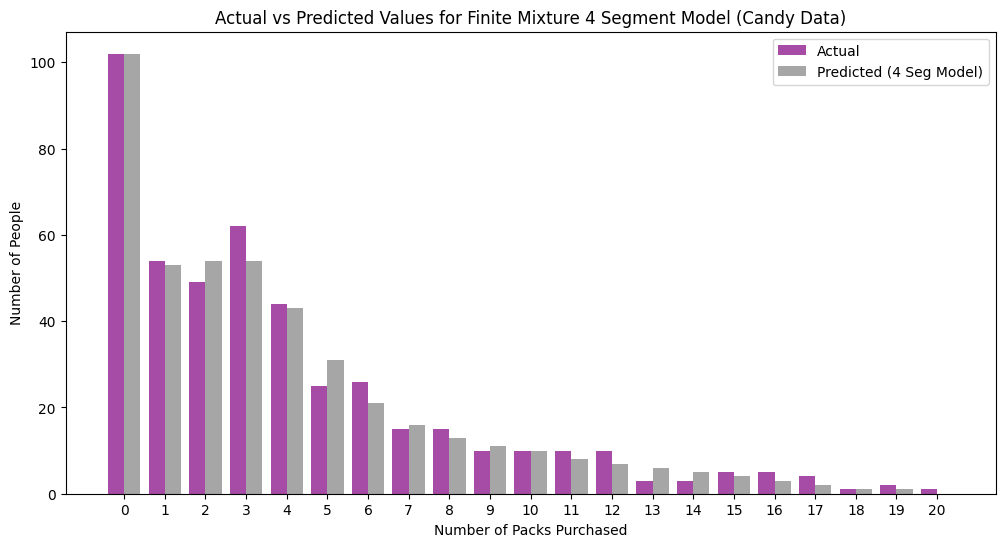

In [31]:
# Graph for original and predicted number of exposures

bar_width = 0.4
index = np.arange(len(k))

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_fmm4segmdl_p1d, width=bar_width, alpha=0.7, label='Predicted (4 Seg Model)', color='gray')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for Finite Mixture 4 Segment Model (Candy Data)')
plt.xticks(index + bar_width / 2, k)
plt.legend()
plt.show()

### 2. Model Evaluation - Hard Candy Example

In [32]:
import math
# Evaluating the model using aic and bic

# AIC=−2×Log-Likelihood+2×Number of Parameters
# BIC=−2×Log-Likelihood+ln(N)×Number of Parameters

# Log likelihood
psnmdl_LL = -psnmdl_soln_p1a.fun
nbdmdl_LL = -nbdmdl_soln_p1b.fun
zinbdmdl_LL = -zinbdmdl_soln_p1c.fun
fmm2segmdl_LL = -fmm2segmdl_soln_p1d.fun
fmm3segmdl_LL = -fmm3segmdl_soln_p1d.fun
fmm4segmdl_LL = -fmm4segmdl_soln_p1d.fun

# Number of Parameters
psnmdl_len = len(psnmdl_soln_p1a.x)
nbdmdl_len = len(nbdmdl_soln_p1b.x)
zinbdmdl_len = len(zinbdmdl_soln_p1c.x)
fmm2segmdl_len = len(fmm2segmdl_soln_p1d.x)
fmm3segmdl_len = len(fmm3segmdl_soln_p1d.x)
fmm4segmdl_len = len(fmm4segmdl_soln_p1d.x)

# AIC
AIC_psnmdl = (-2*psnmdl_LL) + (2*psnmdl_len)
AIC_nbdmdl = (-2*nbdmdl_LL) + (2*nbdmdl_len)
AIC_zinbdmdl = (-2*zinbdmdl_LL) + (2*zinbdmdl_len)
AIC_fmm2segmdl = (-2*fmm2segmdl_LL) + (2*fmm2segmdl_len)
AIC_fmm3segmdl = (-2*fmm3segmdl_LL) + (2*fmm3segmdl_len)
AIC_fmm4segmdl = (-2*fmm4segmdl_LL) + (2*fmm4segmdl_len)

#BIC
N = candy.shape[0]

BIC_psnmdl = (-2*psnmdl_LL) + (math.log(N)*psnmdl_len)
BIC_nbdmdl = (-2*nbdmdl_LL) + (math.log(N)*nbdmdl_len)
BIC_zinbdmdl = (-2*zinbdmdl_LL) + (math.log(N)*zinbdmdl_len)
BIC_fmm2segmdl = (-2*fmm2segmdl_LL) + (math.log(N)*fmm2segmdl_len)
BIC_fmm3segmdl = (-2*fmm3segmdl_LL) + (math.log(N)*fmm3segmdl_len)
BIC_fmm4segmdl = (-2*fmm4segmdl_LL) + (math.log(N)*fmm4segmdl_len)

In [33]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Log-Likelihood (LL)", "No. of Param", "AIC", "BIC"]
table.add_row(["Poisson", psnmdl_LL, psnmdl_len, AIC_psnmdl, BIC_psnmdl])
table.add_row(["NBD", nbdmdl_LL, nbdmdl_len, AIC_nbdmdl, BIC_nbdmdl])
table.add_row(["ZI-NBD", zinbdmdl_LL, zinbdmdl_len, AIC_zinbdmdl, BIC_zinbdmdl])
table.add_row(["2 SEG FM", fmm2segmdl_LL, fmm2segmdl_len, AIC_fmm2segmdl, BIC_fmm2segmdl])
table.add_row(["3 SEG FM", fmm3segmdl_LL, fmm3segmdl_len, AIC_fmm3segmdl, BIC_fmm3segmdl])
table.add_row(["4 SEG FM", fmm4segmdl_LL, fmm4segmdl_len, AIC_fmm4segmdl, BIC_fmm4segmdl])
table.float_format = "0.3"
print(table)

+----------+---------------------+--------------+----------+----------+
|  Model   | Log-Likelihood (LL) | No. of Param |   AIC    |   BIC    |
+----------+---------------------+--------------+----------+----------+
| Poisson  |      -1544.996      |      1       | 3091.993 | 3093.037 |
|   NBD    |      -1140.024      |      2       | 2284.047 | 2286.137 |
|  ZI-NBD  |      -1136.166      |      3       | 2278.331 | 2281.465 |
| 2 SEG FM |      -1188.833      |      3       | 2383.666 | 2386.799 |
| 3 SEG FM |      -1132.043      |      5       | 2274.086 | 2279.309 |
| 4 SEG FM |      -1130.071      |      7       | 2274.141 | 2281.453 |
+----------+---------------------+--------------+----------+----------+


### 3. Finding Purchases in Next 8 weeks - Hard Candy Example

#### 2 Seg FM Model

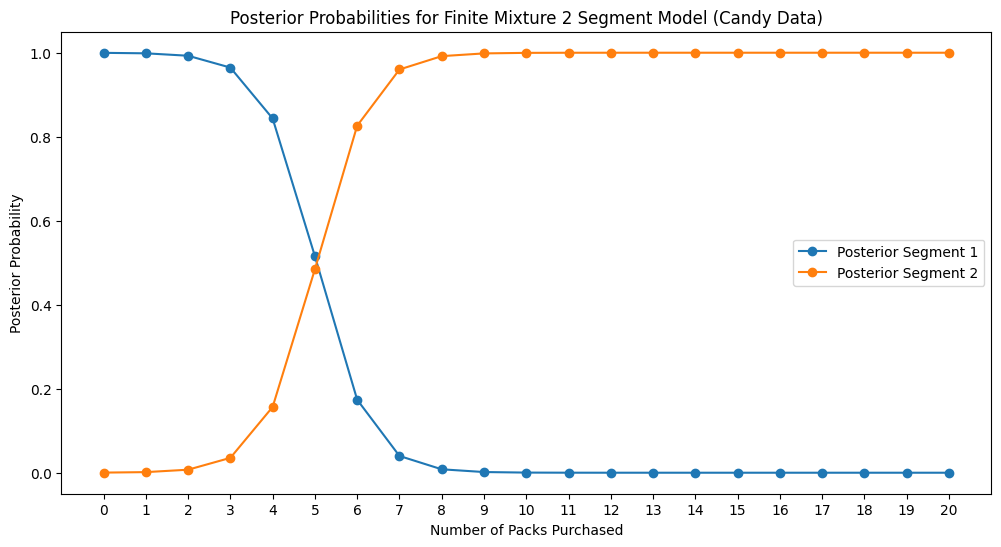

In [34]:
# Predicting Posterior Probability - 2 Seg FM Model
posterior_probs_fmm2p1d = []

for i in range(len(k)):
    prob_segment1 = estimated_pi1_fmm2p1d * poisson.pmf(k[i], estimated_lambda1_fmm2p1d)
    prob_segment2 = (1-estimated_pi1_fmm2p1d) * poisson.pmf(k[i], estimated_lambda2_fmm2p1d)

    sum_probs = prob_segment1 + prob_segment2
    posterior_probs_fmm2p1d.append([prob_segment1 / sum_probs, prob_segment2 / sum_probs])

# Convert posterior probabilities to NumPy array for easier plotting
posterior_probs_array_fmm2p1d = np.array(posterior_probs_fmm2p1d)

# Plot the posterior probabilities using a line graph
index = np.arange(len(k))

plt.figure(figsize=(12, 6))

for i in range(2):  # Loop through each segment
    plt.plot(index, posterior_probs_array_fmm2p1d[:, i], label=f'Posterior Segment {i + 1}', marker='o')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probabilities for Finite Mixture 2 Segment Model (Candy Data)')
plt.xticks(index, k)
plt.legend()
plt.show()

In [35]:
expected_1_week_purchase_fmm2 = []
for i in range(len(posterior_probs_array_fmm2p1d)):
    expected_purchase = ((posterior_probs_array_fmm2p1d[i, 0] * estimated_lambda1_fmm3p1d)+ (posterior_probs_array_fmm2p1d[i,1] * estimated_lambda2_fmm2p1d))
    expected_1_week_purchase_fmm2.append(expected_purchase)

# Convert the list to a NumPy array
expected_purchases_1_week_fmm2 = np.array(expected_1_week_purchase_fmm2)

expected_8_week_purchase_fmm2 = []
for i in range(len(posterior_probs_array_fmm2p1d)):
    expected_purchase = 8 * expected_1_week_purchase_fmm2[i]
    expected_8_week_purchase_fmm2.append(expected_purchase)

# Convert the list to a NumPy array
expected_purchases_8_week_fmm2 = np.array(expected_8_week_purchase_fmm2)

print("customer who purchased 5 packs in the past weeks: ", expected_purchases_8_week_fmm2[5])
print("customer who purchased 9 packs in the past weeks: ", expected_purchases_8_week_fmm2[9])

customer who purchased 5 packs in the past weeks:  49.71471996469466
customer who purchased 9 packs in the past weeks:  72.8924509398868


#### 3 Seg FM Model

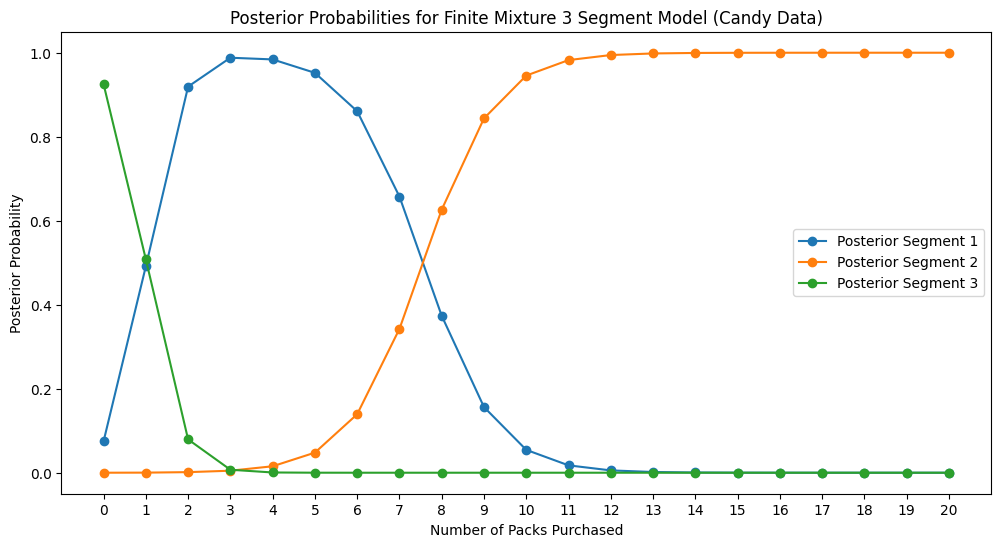

In [36]:
# Predicting Posterior Probability - 3 Seg FM Model
posterior_probs_p1d_fmm3 = []

theta3 = 0
exp_theta1 = np.exp(estimated_theta1_fmm3p1d)
exp_theta2 = np.exp(estimated_theta2_fmm3p1d)
exp_theta3 = np.exp(theta3)
sum_thetas = exp_theta1+exp_theta2+exp_theta3

pi1 = exp_theta1/sum_thetas
pi2 = exp_theta2/sum_thetas
pi3 = exp_theta3/sum_thetas

for i in range(len(k)):
    prob_segment1 = pi1 * poisson.pmf(k[i], estimated_lambda1_fmm3p1d)
    prob_segment2 = pi2 * poisson.pmf(k[i], estimated_lambda2_fmm3p1d)
    prob_segment3 = pi3 * poisson.pmf(k[i], estimated_lambda3_fmm3p1d)

    sum_probs = prob_segment1 + prob_segment2 + prob_segment3

    posterior_probs_p1d_fmm3.append([prob_segment1 / sum_probs, prob_segment2 / sum_probs, prob_segment3 / sum_probs])

# Convert posterior probabilities to NumPy array for easier plotting
posterior_probs_array_p1d_fmm3 = np.array(posterior_probs_p1d_fmm3)

# Plot the posterior probabilities using a line graph
index = np.arange(len(k))

plt.figure(figsize=(12, 6))

for i in range(3):  # Loop through each segment
    plt.plot(index, posterior_probs_array_p1d_fmm3[:, i], label=f'Posterior Segment {i + 1}', marker='o')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probabilities for Finite Mixture 3 Segment Model (Candy Data)')
plt.xticks(index, k)
plt.legend()
plt.show()

In [37]:
expected_1_week_purchase_fmm3 = []
for i in range(len(posterior_probs_array_p1d_fmm3)):
    expected_purchase = ((posterior_probs_array_p1d_fmm3[i, 0] * estimated_lambda1_fmm3p1d)+ (posterior_probs_array_p1d_fmm3[i,1] * estimated_lambda2_fmm3p1d) + (posterior_probs_array_p1d_fmm3[i,2] * estimated_lambda3_fmm3p1d))
    expected_1_week_purchase_fmm3.append(expected_purchase)

# Convert the list to a NumPy array
expected_purchases_1_week_fmm3 = np.array(expected_1_week_purchase_fmm3)

expected_8_week_purchase_fmm3 = []
for i in range(len(posterior_probs_array_p1d_fmm3)):
    expected_purchase = 8 * expected_1_week_purchase_fmm3[i]
    expected_8_week_purchase_fmm3.append(expected_purchase)

# Convert the list to a NumPy array
expected_purchases_8_week_fmm3 = np.array(expected_8_week_purchase_fmm3)

print("customer who purchased 5 packs in the past weeks: ", expected_purchases_8_week_fmm3[5])
print("customer who purchased 9 packs in the past weeks: ", expected_purchases_8_week_fmm3[9])

customer who purchased 5 packs in the past weeks:  30.825246830490574
customer who purchased 9 packs in the past weeks:  80.06282859753176


#### 4 Seg FM Model

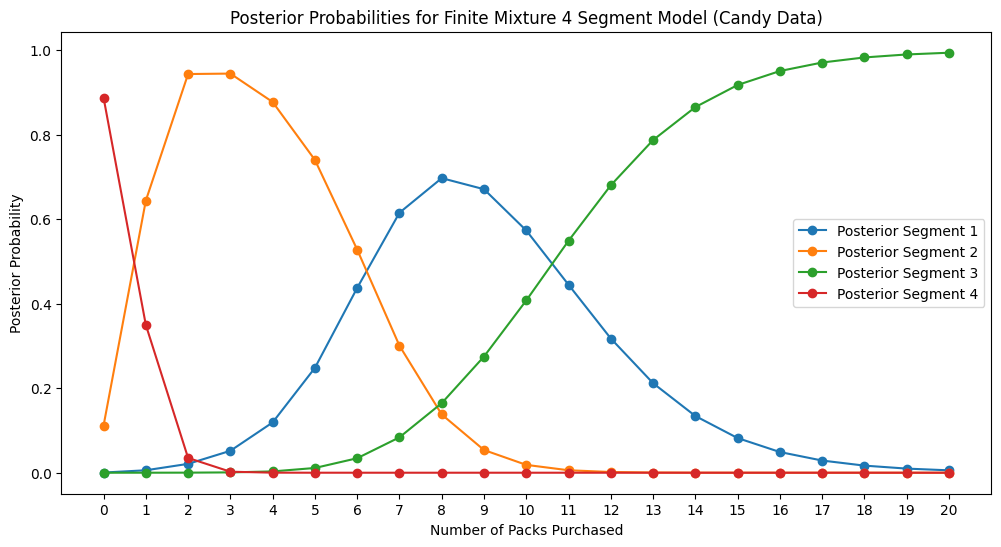

In [38]:
# Predicting Posterior Probability - 4 Seg FM Model
posterior_probs_p1d_fmm4 = []

theta4_fmm4 = 0

exp_theta1_fmm4 = np.exp(estimated_theta1_fmm4p1d)
exp_theta2_fmm4 = np.exp(estimated_theta2_fmm4p1d)
exp_theta3_fmm4 = np.exp(estimated_theta3_fmm4p1d)
exp_theta4_fmm4 = np.exp(theta4_fmm4)

sum_thetas_fmm4 = exp_theta1_fmm4+exp_theta2_fmm4+exp_theta3_fmm4+exp_theta4_fmm4

pi1_fmm4 = exp_theta1_fmm4/sum_thetas_fmm4
pi2_fmm4 = exp_theta2_fmm4/sum_thetas_fmm4
pi3_fmm4 = exp_theta3_fmm4/sum_thetas_fmm4
pi4_fmm4 = exp_theta4_fmm4/sum_thetas_fmm4

for i in range(len(k)):
    prob_segment1_fmm4 = pi1_fmm4 * poisson.pmf(k[i], estimated_lambda1_fmm4p1d)
    prob_segment2_fmm4 = pi2_fmm4 * poisson.pmf(k[i], estimated_lambda2_fmm4p1d)
    prob_segment3_fmm4 = pi3_fmm4 * poisson.pmf(k[i], estimated_lambda3_fmm4p1d)
    prob_segment4_fmm4 = pi4_fmm4 * poisson.pmf(k[i], estimated_lambda4_fmm4p1d)

    sum_probs_fmm4 = prob_segment1_fmm4 + prob_segment2_fmm4 + prob_segment3_fmm4 + prob_segment4_fmm4

    posterior_probs_p1d_fmm4.append([prob_segment1_fmm4 / sum_probs_fmm4, prob_segment2_fmm4 / sum_probs_fmm4, prob_segment3_fmm4 / sum_probs_fmm4, prob_segment4_fmm4 / sum_probs_fmm4])

# Convert posterior probabilities to NumPy array for easier plotting
posterior_probs_array_p1d_fmm4 = np.array(posterior_probs_p1d_fmm4)

# Plot the posterior probabilities using a line graph
index = np.arange(len(k))

plt.figure(figsize=(12, 6))

for i in range(4):  # Loop through each segment
    plt.plot(index, posterior_probs_array_p1d_fmm4[:, i], label=f'Posterior Segment {i + 1}', marker='o')

plt.xlabel('Number of Packs Purchased')
plt.ylabel('Posterior Probability')
plt.title('Posterior Probabilities for Finite Mixture 4 Segment Model (Candy Data)')
plt.xticks(index, k)
plt.legend()
plt.show()

In [39]:
expected_1_week_purchase_fmm4 = []
for i in range(len(posterior_probs_array_p1d_fmm4)):
    expected_purchase = ((posterior_probs_array_p1d_fmm4[i, 0] * estimated_lambda1_fmm4p1d)+ (posterior_probs_array_p1d_fmm4[i,1] * estimated_lambda2_fmm4p1d) + (posterior_probs_array_p1d_fmm4[i,2] * estimated_lambda3_fmm4p1d) + (posterior_probs_array_p1d_fmm4[i,3] * estimated_lambda4_fmm4p1d))
    expected_1_week_purchase_fmm4.append(expected_purchase)

# Convert the list to a NumPy array
expected_purchases_1_week_fmm4 = np.array(expected_1_week_purchase_fmm4)

expected_8_week_purchase_fmm4 = []
for i in range(len(posterior_probs_array_p1d_fmm4)):
    expected_purchase = 8 * expected_1_week_purchase_fmm4[i]
    expected_8_week_purchase_fmm4.append(expected_purchase)

# Convert the list to a NumPy array
expected_purchases_8_week_fmm4 = np.array(expected_8_week_purchase_fmm4)

print("customer who purchased 5 packs in the past weeks: ", expected_purchases_8_week_fmm4[5])
print("customer who purchased 9 packs in the past weeks: ", expected_purchases_8_week_fmm4[9])

customer who purchased 5 packs in the past weeks:  33.67147248894754
customer who purchased 9 packs in the past weeks:  69.45336986379394


## Part 2 - Analysis of New Data

In [41]:
# Bringing in Articles Dataset

# Load the dataset
articles_df = pd.read_csv("/content/sample_data/articles.csv")

# Variable Types
print("Data Type: ")
print(articles_df.dtypes)
print("")

# Shape of the dataset
print("Shape of dataframe: ", articles_df.shape)
print("")

# First five records in the dataset
print(articles_df.head(5))

Data Type: 
articles      int64
female        int64
married       int64
kids          int64
prestige    float64
menpubs       int64
dtype: object

Shape of dataframe:  (915, 6)

   articles  female  married  kids  prestige  menpubs
0         0       0        1     0      2.52        7
1         0       1        0     0      2.05        6
2         0       1        0     0      3.75        6
3         0       0        1     1      1.18        3
4         0       1        0     0      3.75       26


### 1. Poisson Regression - Articles Example

In [42]:
# Defining functions to calculate probability p(x=k) and negative log likelihood of the poisson regression
# Poisson Regression - khakichinos dataset
# poisson regression param - lambda, beta1, beta2, beta3, beta4
def psnreg_log_likelihood_p2q1(params, v, x1, x2, x3, x4, x5):
    lambda0, beta1, beta2, beta3, beta4, beta5 = params
    obs = list(range(0, len(v)))
    prll = 0
    lambdai, prob = [], []
    for i in obs:
        lambdai.append(lambda0 * np.exp(beta1*x1[i] + beta2*x2[i] + beta3*x3[i] + beta4*x4[i] + beta5*x5[i]))
        prob.append(poisson.pmf(v[i],lambdai[i]))
        prll += np.log(prob[i] + 1e-45)
    return prll

def psnreg_neg_log_likelihood_p2q1(params, v, x1, x2, x3, x4, x5):
    return -psnreg_log_likelihood_p2q1(params, v, x1, x2, x3, x4, x5)

In [43]:
# Defining Variables
v = articles_df["articles"].values
x1 = articles_df["female"].values
x2 = articles_df["married"].values
x3 = articles_df["kids"].values
x4 = articles_df["prestige"].values
x5 = articles_df["menpubs"].values

# Initial guess for poisson regression parameters (lambda, beta1, beta2, beta3, beta4)
initial_params_p2q1 = np.array([0.5,0.01,0.01,0.02,-0.01, 0.01])

# Perform Maximum Likelihood Estimation for Poisson Regression
psnreg_soln_p2q1 = minimize(
    psnreg_neg_log_likelihood_p2q1,
    x0=initial_params_p2q1,
    args=(v, x1, x2, x3, x4, x5),
    bounds=[(0.000001, None),(None, None),(None, None),(None, None),(None, None),(None, None)],
    tol=1e-10,
    options={'ftol': 1e-8},)

# Extract the estimated poisson regression parameters and maximum log-likelihood
estimated_lambda0_p2q1, estimated_beta1_p2q1, estimated_beta2_p2q1, estimated_beta3_p2q1, estimated_beta4_p2q1, estimated_beta5_p2q1 = psnreg_soln_p2q1.x
max_log_likelihood_psnreg_p2q1 = -psnreg_soln_p2q1.fun

# Print the results
print("Estimated Poisson Regression Parameters:", estimated_lambda0_p2q1, estimated_beta1_p2q1, estimated_beta2_p2q1, estimated_beta3_p2q1, estimated_beta4_p2q1, estimated_beta5_p2q1)
print("Maximum Log-Likelihood (Poisson Regression):", max_log_likelihood_psnreg_p2q1)

Estimated Poisson Regression Parameters: 1.356386492148416 -0.2246916785231341 0.15524250142573223 -0.18492134446124522 0.012764993637619107 0.02554587430001458
Maximum Log-Likelihood (Poisson Regression): -1651.0563210621242


In [44]:
# creating a dataset with two columns - NumberOfArticles and the corresponding Number of Visitors
articles_df['ID'] = range(1, len(articles_df) + 1)
articles_count = articles_df.groupby('articles', as_index=False).agg({'ID': 'count'})
articles_count.rename(columns={'ID':'NumberofPeople'}, inplace=True)
articles_count.rename(columns={'articles':'NumberofArticles'}, inplace=True)

# Defining variables
x = articles_count['NumberofPeople'].values
unique_articles = articles_count['NumberofArticles'].values

# Initializing empty lists to store the means for each predictor variable
mean_x1_values, mean_x2_values, mean_x3_values, mean_x4_values, mean_x5_values = [], [], [], [], []

# Calculate mean values for each predictor variable for each unique visit count
for articles in unique_articles:
    subset = articles_df[articles_df["articles"] == articles]
    mean_x1_values.append(subset["female"].mean())
    mean_x2_values.append(subset["married"].mean())
    mean_x3_values.append(subset["kids"].mean())
    mean_x4_values.append(subset["prestige"].mean())
    mean_x5_values.append(subset["menpubs"].mean())

In [45]:
#Prediction
# Defining Variables
predicted_probabilities_p2q1 = []
total_people = sum(x)

# Defining poisson regression function to calculate probability for each unique visit
def psnreg_prob_p2q1(params, v, x1, x2, x3, x4, x5):
    lambda0, beta1, beta2, beta3, beta4, beta5 = params
    lambdai = lambda0 * np.exp(beta1*x1 + beta2*x2 + beta3*x3 + beta4*x4 + beta5*x5)
    prob = poisson.pmf(v,lambdai)
    return prob

# Predicting Probability
for i in range(len(unique_articles)):
    probabilities_p2q1 = psnreg_prob_p2q1(psnreg_soln_p2q1.x, unique_articles[i], mean_x1_values[i],
                                               mean_x2_values[i], mean_x3_values[i], mean_x4_values[i], mean_x5_values[i])
    predicted_probabilities_p2q1.append(probabilities_p2q1)

# Predicting Number of Visitors
predicted_people_psnreg_p2q1 = [int(p * total_people) for p in predicted_probabilities_p2q1]

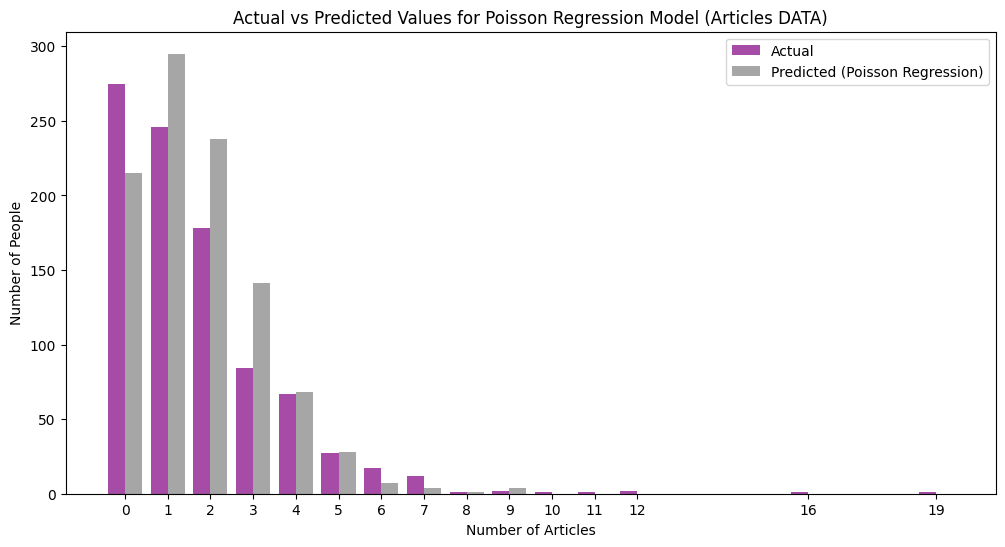

In [46]:
# Graph for original and predicted number of visitors (Khakichinos Dataset)
bar_width = 0.4
index = unique_articles

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_psnreg_p2q1, width=bar_width, alpha=0.7, label='Predicted (Poisson Regression)', color='gray')

plt.xlabel('Number of Articles')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for Poisson Regression Model (Articles DATA)')
plt.xticks(index + bar_width / 2, unique_articles)
plt.legend()
plt.show()

### 2. NBD Regression - Articles Example

In [47]:
# NBD Regression - khakichinos dataset
def nbdreg_log_likelihood_p2q2(params, v, x1, x2, x3, x4, x5):
    n, alpha, beta1, beta2, beta3, beta4, beta5 = params
    obs = list(range(0, len(v)))
    nbdrll = 0
    exp_beta, part1, part2, part3, prob = [], [], [], [], []

    for i in obs:
        exp_beta.append(np.exp(beta1*x1[i] + beta2*x2[i] + beta3*x3[i] + beta4*x4[i] + beta5*x5[i]))
        part1.append(gamma(n+v[i])/(gamma(n)*math.factorial(v[i])))
        part2.append((alpha/(alpha+exp_beta[i]))**n)
        part3.append((exp_beta[i]/(alpha+exp_beta[i]))**v[i])
        prob.append(part1[i]*part2[i]*part3[i])
        nbdrll += np.log(prob[i])
    return nbdrll

def nbdreg_neg_log_likelihood_p2q2(params, v, x1, x2, x3, x4, x5):
    return -nbdreg_log_likelihood_p2q2(params, v, x1, x2, x3, x4, x5)

In [48]:
# Initial guess for NBD Regression parameters (n, alpha, beta1, beta2, beta3, beta4, beta5)
initial_params_p2q2 = np.array([0.02,0.05,0.01,0.01,0.02,-0.01, 0.01])

# Perform Maximum Likelihood Estimation for NBD
nbdreg_soln_p2q2 = minimize(
    nbdreg_neg_log_likelihood_p2q2,
    x0=initial_params_p2q2,
    args=(v, x1, x2, x3, x4, x5),
    bounds=[(0.000001, None),(0.000001, None),(None, None),(None, None),(None, None),(None, None),(None, None)],
    tol=1e-10,
    options={'ftol': 1e-8},
)

# Extract the estimated NBD parameters and maximum log-likelihood
estimated_n_p2q2, estimated_alpha_p2q2, estimated_beta1_p2q2, estimated_beta2_p2q2, estimated_beta3_p2q2, estimated_beta4_p2q2, estimated_beta5_p2q2  = nbdreg_soln_p2q2.x
max_log_likelihood_nbdreg_p2q2 = -nbdreg_soln_p2q2.fun

# Print the results
print("Estimated NBD Regression Parameters:", estimated_n_p2q2, estimated_alpha_p2q2, estimated_beta1_p2q2, estimated_beta2_p2q2, estimated_beta3_p2q2, estimated_beta4_p2q2, estimated_beta5_p2q2)
print("Maximum Log-Likelihood (NBD Regression):", max_log_likelihood_nbdreg_p2q2)

Estimated NBD Regression Parameters: 2.264588170585852 1.7528169085375391 -0.2164925264234801 0.15048373390087377 -0.17638293524692333 0.015270092575949945 0.02908168379167232
Maximum Log-Likelihood (NBD Regression): -1560.9583398020238


In [49]:
#Defining nbd regression function to predict probability for each unique visit
def nbdreg_prob_p2q2(params, v, x1, x2, x3, x4, x5):
    n, alpha, beta1, beta2, beta3, beta4, beta5 = params
    exp_beta, part1, part2, part3, prob = 0,0,0,0,0

    exp_beta = (np.exp(beta1*x1 + beta2*x2 + beta3*x3 + beta4*x4 + beta5*x5))
    part1 = (gamma(n+v)/(gamma(n)*math.factorial(v)))
    part2 = ((alpha/(alpha+exp_beta))**n)
    part3 = ((exp_beta/(alpha+exp_beta))**v)
    prob = (part1*part2*part3)
    return prob

#Defining Variable
predicted_probabilities_p2q2 = []

#Predicting probabilities for unique_visits
for i in range(len(unique_articles)):
    probabilities_p2q2 = nbdreg_prob_p2q2(nbdreg_soln_p2q2.x, unique_articles[i], mean_x1_values[i],
                                               mean_x2_values[i], mean_x3_values[i], mean_x4_values[i], mean_x5_values[i])
    predicted_probabilities_p2q2.append(probabilities_p2q2)

predicted_people_nbdreg_p2q2 = [int(p * total_people) for p in predicted_probabilities_p2q2]

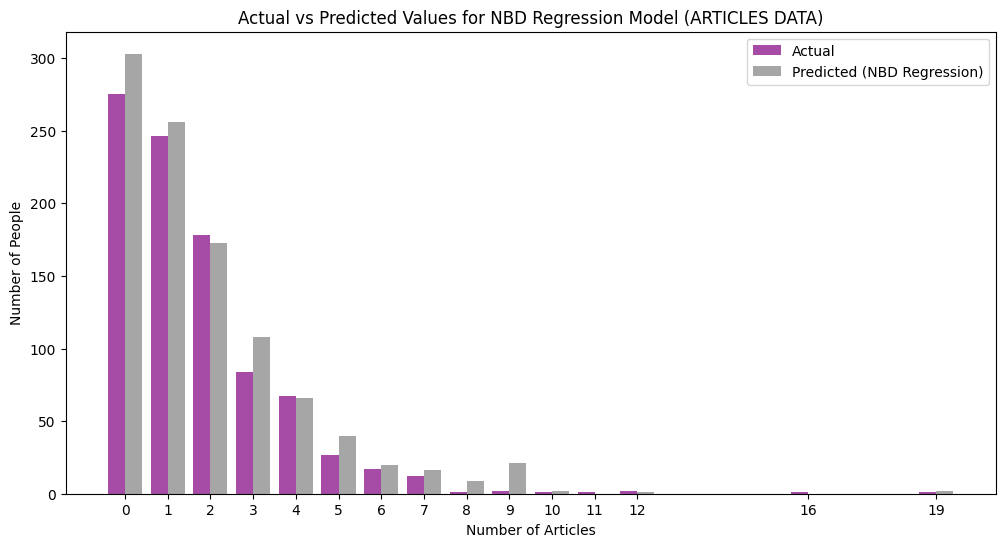

In [50]:
# Graph for original and predicted number of exposures
bar_width = 0.4
index = unique_articles

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_nbdreg_p2q2, width=bar_width, alpha=0.7, label='Predicted (NBD Regression)', color='gray')

plt.xlabel('Number of Articles')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for NBD Regression Model (ARTICLES DATA)')
plt.xticks(index + bar_width / 2, unique_articles)
plt.legend()
plt.show()

### 3. ZERO INFLATED NBD Regression - Articles Example

In [51]:
# NBD Regression - khakichinos dataset
def zinbdreg_log_likelihood_p2q3(params, v, x1, x2, x3, x4, x5):
    n, alpha, beta1, beta2, beta3, beta4, beta5, pi = params
    obs = list(range(0, len(v)))
    zinbdrll = 0
    exp_beta, part1, part2, part3, prob = [], [], [], [], []

    for i in obs:
        exp_beta.append(np.exp(beta1*x1[i] + beta2*x2[i] + beta3*x3[i] + beta4*x4[i] + beta5*x5[i]))
        part1.append(gamma(n+v[i])/(gamma(n)*math.factorial(v[i])))
        part2.append((alpha/(alpha+exp_beta[i]))**n)
        part3.append((exp_beta[i]/(alpha+exp_beta[i]))**v[i])
        prob.append((pi if v[i] == 0 else 0) + (1-pi) * part1[i]*part2[i]*part3[i])
        zinbdrll += np.log(prob[i])
    return zinbdrll

def zinbdreg_neg_log_likelihood_p2q3(params, v, x1, x2, x3, x4, x5):
    return -zinbdreg_log_likelihood_p2q3(params, v, x1, x2, x3, x4, x5)

In [52]:
# Initial guess for NBD Regression parameters (n, alpha, beta1, beta2, beta3, beta4, beta5)
initial_params_p2q3 = np.array([0.02,0.05,0.01,0.01,0.02,-0.01, 0.01, 0.05])

# Perform Maximum Likelihood Estimation for NBD
zinbdreg_soln_p2q3 = minimize(
    zinbdreg_neg_log_likelihood_p2q3,
    x0=initial_params_p2q3,
    args=(v, x1, x2, x3, x4, x5),
    bounds=[(0.000001, None),(0.000001, None),(None, None),(None, None),(None, None),(None, None),(None, None), (0.000001, 0.99999)],
    tol=1e-10,
    options={'ftol': 1e-8},
)

# Extract the estimated NBD parameters and maximum log-likelihood
estimated_n_p2q3, estimated_alpha_p2q3, estimated_beta1_p2q3, estimated_beta2_p2q3, estimated_beta3_p2q3, estimated_beta4_p2q3, estimated_beta5_p2q3, estimated_pi_p2q3  = zinbdreg_soln_p2q3.x
max_log_likelihood_zinbdreg_p2q3 = -zinbdreg_soln_p2q3.fun

# Print the results
print("Estimated ZI NBD Regression Parameters:", estimated_n_p2q3, estimated_alpha_p2q3, estimated_beta1_p2q3, estimated_beta2_p2q3, estimated_beta3_p2q3, estimated_beta4_p2q3, estimated_beta5_p2q3, estimated_pi_p2q3)
print("Maximum Log-Likelihood (ZI NBD Regression):", max_log_likelihood_zinbdreg_p2q3)

Estimated ZI NBD Regression Parameters: 2.2646131265702336 1.7533444917662122 -0.21648238236708722 0.15057135236052457 -0.17635103890555914 0.015333190003517187 0.02908264503119874 1e-06
Maximum Log-Likelihood (ZI NBD Regression): -1560.9583926419843


In [53]:
#Defining nbd regression function to predict probability for each unique visit
def zinbdreg_prob_p2q3(params, v, x1, x2, x3, x4, x5):
    n, alpha, beta1, beta2, beta3, beta4, beta5, pi = params

    exp_beta = (np.exp(beta1*x1 + beta2*x2 + beta3*x3 + beta4*x4 + beta5*x5))
    part1 = gamma(n+v)/(gamma(n)*math.factorial(v))
    part2 = (alpha/(alpha+exp_beta))**n
    part3 = ((exp_beta/(alpha+exp_beta))**v)
    prob = (pi if v == 0 else 0) + ((1 - pi) * part1 * part2 * part3)

    return prob

#Defining Variable
predicted_probabilities_p2q3 = []

#Predicting probabilities for unique_visits
for i in range(len(unique_articles)):
    probabilities_p2q3 = zinbdreg_prob_p2q3(zinbdreg_soln_p2q3.x, unique_articles[i], mean_x1_values[i],
                                               mean_x2_values[i], mean_x3_values[i], mean_x4_values[i], mean_x5_values[i])
    predicted_probabilities_p2q3.append(probabilities_p2q3)

predicted_people_zinbdreg_p2q3 = [int(p * total_people) for p in predicted_probabilities_p2q3]

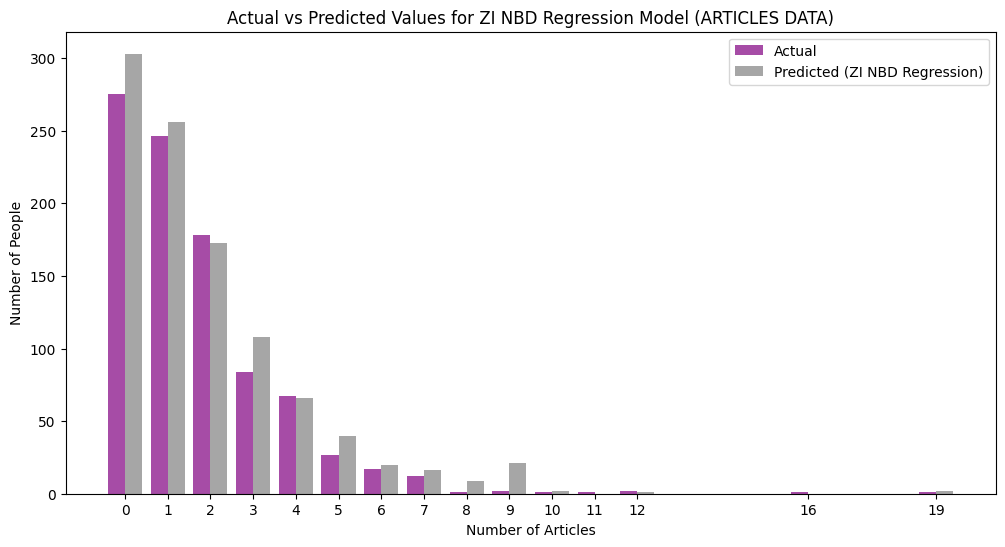

In [54]:
# Graph for original and predicted number of exposures
bar_width = 0.4
index = unique_articles

plt.figure(figsize=(12, 6))
plt.bar(index, x, width=bar_width, alpha=0.7, label='Actual', color='purple')
plt.bar(index + bar_width, predicted_people_zinbdreg_p2q3, width=bar_width, alpha=0.7, label='Predicted (ZI NBD Regression)', color='gray')

plt.xlabel('Number of Articles')
plt.ylabel('Number of People')
plt.title('Actual vs Predicted Values for ZI NBD Regression Model (ARTICLES DATA)')
plt.xticks(index + bar_width / 2, unique_articles)
plt.legend()
plt.show()

### 4. MODEL EVALUATION - Articles Example

In [55]:
# Evaluating the model using aic and bic

# AIC=−2×Log-Likelihood+2×Number of Parameters
# BIC=−2×Log-Likelihood+log(N)×Number of Parameters

# Log likelihood
psnreg_LL = -psnreg_soln_p2q1.fun
nbdreg_LL = -nbdreg_soln_p2q2.fun
zinbdreg_LL = -zinbdreg_soln_p2q3.fun

# Number of Parameters
psnreg_len = len(psnreg_soln_p2q1.x)
nbdreg_len = len(nbdreg_soln_p2q2.x)
zinbdreg_len = len(zinbdreg_soln_p2q3.x)

# AIC
AIC_psnreg = (-2*psnreg_LL) + (2*psnreg_len)
AIC_nbdreg = (-2*nbdreg_LL) + (2*nbdreg_len)
AIC_zinbdreg = (-2*zinbdreg_LL) + (2*zinbdreg_len)

#BIC
N = articles_df.shape[0]

BIC_psnreg = (-2*psnreg_LL) + (np.log(N)*psnreg_len)
BIC_nbdreg = (-2*nbdreg_LL) + (np.log(N)*nbdreg_len)
BIC_zinbdreg = (-2*zinbdreg_LL) + (np.log(N)*zinbdreg_len)

In [56]:
from prettytable import PrettyTable

table = PrettyTable()
table.field_names = ["Model", "Log-Likelihood (LL)", "No. of Param", "AIC", "BIC"]
table.add_row(["Poisson Regression", psnreg_LL, psnreg_len, AIC_psnreg, BIC_psnreg])
table.add_row(["NBD Regression", nbdreg_LL, nbdreg_len, AIC_nbdreg, BIC_nbdreg])
table.add_row(["ZI-NBD Regression", zinbdreg_LL, zinbdreg_len, AIC_zinbdreg, BIC_zinbdreg])
table.float_format = "0.3"
print(table)

+--------------------+---------------------+--------------+----------+----------+
|       Model        | Log-Likelihood (LL) | No. of Param |   AIC    |   BIC    |
+--------------------+---------------------+--------------+----------+----------+
| Poisson Regression |      -1651.056      |      6       | 3314.113 | 3343.026 |
|   NBD Regression   |      -1560.958      |      7       | 3135.917 | 3169.649 |
| ZI-NBD Regression  |      -1560.958      |      8       | 3137.917 | 3176.468 |
+--------------------+---------------------+--------------+----------+----------+
